In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Load dữ liệu
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

# Chuyển đổi Date thành datetime
train_data["Date"] = pd.to_datetime(train_data["Date"])
test_data["Date"] = pd.to_datetime(test_data["Date"])


In [3]:
train_data.head(2)

,ProductID,Date,Zip,Units,Revenue,COGS,City,State,Region,District,Category,Segment,Product
0,676,2010-07-04,8075,1,10048.50,9342.090450,"Riverside, NJ",NJ,East,District #04,Urban,Convenience,Maximus UC-41
1,1041,2010-07-04,56334,1,11651.85,5941.278315,"Glenwood, MN",MN,Central,District #32,Urban,Convenience,Palma UC-13


In [4]:
test_data.head(2)

,ProductID,Date,Zip,Units,Revenue,COGS,City,State,Region,District,Category,Segment,Product
0,688,2021-01-01,11572,1,6740.37,5150.990754,"Oceanside, NY",NY,East,District #03,Urban,Convenience,Maximus UC-53
1,1177,2021-01-01,80229,1,3149.37,3294.241020,"Denver, CO",CO,Central,District #20,Urban,Extreme,Pirum UE-13


In [5]:
# Tạo features tổng hợp theo tháng
def create_monthly_features(df):
    # Tạo các features tổng hợp theo tháng
    monthly_data = (
        df.groupby([df["Date"].dt.to_period("M").astype(str)])
        .agg(
            {
                "Revenue": "sum",
                "Units": "sum",
                "COGS": "sum",
                "ProductID": "nunique",  # Số lượng sản phẩm khác nhau
                "Category": lambda x: x.nunique(),  # Số lượng category
                "State": lambda x: x.nunique(),  # Số lượng state
            }
        )
        .reset_index()
    )

    # Chuyển Date về datetime để tạo thêm features thời gian
    monthly_data["Date"] = pd.to_datetime(monthly_data["Date"])

    # Thêm features thời gian
    monthly_data["Year"] = monthly_data["Date"].dt.year
    monthly_data["Month"] = monthly_data["Date"].dt.month
    monthly_data["Quarter"] = monthly_data["Date"].dt.quarter

    # Tạo các features tỷ lệ
    monthly_data["Revenue_per_Unit"] = monthly_data["Revenue"] / monthly_data["Units"]
    monthly_data["COGS_per_Unit"] = monthly_data["COGS"] / monthly_data["Units"]
    monthly_data["Profit_Margin"] = (
        monthly_data["Revenue"] - monthly_data["COGS"]
    ) / monthly_data["Revenue"]

    # Tạo lag features
    for lag in [1, 2, 3, 6, 12]:
        monthly_data[f"Revenue_Lag_{lag}"] = monthly_data["Revenue"].shift(lag)
        monthly_data[f"Units_Lag_{lag}"] = monthly_data["Units"].shift(lag)
        monthly_data[f"Revenue_per_Unit_Lag_{lag}"] = monthly_data[
            "Revenue_per_Unit"
        ].shift(lag)
        monthly_data[f"Profit_Margin_Lag_{lag}"] = monthly_data["Profit_Margin"].shift(
            lag
        )

    # Tạo rolling mean features
    for window in [3, 6, 12]:
        monthly_data[f"Revenue_Rolling_Mean_{window}"] = (
            monthly_data["Revenue"].rolling(window=window, min_periods=1).mean()
        )
        monthly_data[f"Units_Rolling_Mean_{window}"] = (
            monthly_data["Units"].rolling(window=window, min_periods=1).mean()
        )
        monthly_data[f"Revenue_Rolling_Std_{window}"] = (
            monthly_data["Revenue"].rolling(window=window, min_periods=1).std()
        )
        monthly_data[f"Units_Rolling_Std_{window}"] = (
            monthly_data["Units"].rolling(window=window, min_periods=1).std()
        )

    # Tạo YoY features
    monthly_data["Revenue_YoY"] = monthly_data["Revenue"].pct_change(periods=12)
    monthly_data["Units_YoY"] = monthly_data["Units"].pct_change(periods=12)

    # Tạo features mùa vụ
    monthly_data["Month_Sin"] = np.sin(2 * np.pi * monthly_data["Month"] / 12)
    monthly_data["Month_Cos"] = np.cos(2 * np.pi * monthly_data["Month"] / 12)

    # Điền missing values
    for col in monthly_data.columns:
        if monthly_data[col].isnull().any():
            # Trước tiên thử điền bằng giá trị gần nhất phía trước
            monthly_data[col] = monthly_data[col].fillna(method="ffill")
            # Nếu vẫn còn NA, điền bằng giá trị gần nhất phía sau
            monthly_data[col] = monthly_data[col].fillna(method="bfill")
            # Nếu vẫn còn NA (ở đầu hoặc cuối series), điền bằng mean
            monthly_data[col] = monthly_data[col].fillna(monthly_data[col].mean())

    return monthly_data


# Tạo dữ liệu tổng hợp theo tháng
print("Đang tạo features...")
monthly_train = create_monthly_features(train_data)
monthly_test = create_monthly_features(test_data)

print("\nThông tin về dữ liệu sau khi tạo features:")
print("\nTrain shape:", monthly_train.shape)
print("Test shape:", monthly_test.shape)


Đang tạo features...

Thông tin về dữ liệu sau khi tạo features:

Train shape: (126, 49)
Test shape: (19, 49)


In [6]:
# Chuẩn bị features cho model
features_to_drop = ["Date", "Revenue"]
target = "Revenue"

X_train = monthly_train.drop(features_to_drop, axis=1)
y_train = monthly_train[target]
X_test = monthly_test.drop(features_to_drop, axis=1)
y_test = monthly_test[target]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Tham số cho mô hình
params = {
    "objective": "reg:squarederror",
    "eval_metric": ["rmse", "mae"],
    "max_depth": 4,
    "learning_rate": 0.02,
    "n_estimators": 1100,
    "min_child_weight": 8,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "gamma": 1.0,
    "reg_alpha": 1.5,
    "reg_lambda": 4.0,
    "random_state": 42,
}

In [8]:
# Add time-series cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store cross-validation scores
cv_scores_rmse = []
cv_scores_mape = []

print("\nPerforming Time Series Cross-validation...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    X_train_cv = X_train_scaled[train_idx]
    y_train_cv = y_train.iloc[train_idx]
    X_val_cv = X_train_scaled[val_idx]
    y_val_cv = y_train.iloc[val_idx]

    dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv)
    dval_cv = xgb.DMatrix(X_val_cv, label=y_val_cv)

    # Train model
    model_cv = xgb.train(
        params,
        dtrain_cv,
        num_boost_round=1000,  # Specify number of boosting rounds
        evals=[(dtrain_cv, "train"), (dval_cv, "val")],
        early_stopping_rounds=50,  # Specify early stopping rounds
        verbose_eval=False,
    )

    # Make predictions
    val_pred = model_cv.predict(dval_cv)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val_cv, val_pred))
    mape = np.mean(np.abs((y_val_cv - val_pred) / y_val_cv) * 100)

    cv_scores_rmse.append(rmse)
    cv_scores_mape.append(mape)

    print(f"Fold {fold + 1}: RMSE = {rmse:,.2f}, MAPE = {mape:.2f}%")

print("\nCross-validation Results:")
print(f"Average RMSE: {np.mean(cv_scores_rmse):,.2f} (±{np.std(cv_scores_rmse):,.2f})")
print(f"Average MAPE: {np.mean(cv_scores_mape):.2f}% (±{np.std(cv_scores_mape):.2f}%)")



Performing Time Series Cross-validation...
Fold 1: RMSE = 11,036,656.06, MAPE = 14.28%
Fold 2: RMSE = 8,574,460.32, MAPE = 7.35%
Fold 3: RMSE = 5,791,524.26, MAPE = 15.20%
Fold 4: RMSE = 5,168,042.30, MAPE = 22.04%
Fold 5: RMSE = 1,636,798.22, MAPE = 5.05%

Cross-validation Results:
Average RMSE: 6,441,496.23 (±3,187,296.69)
Average MAPE: 12.78% (±6.05%)


In [9]:
# Train final model with updated parameters
print("\nTraining final model...")
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=50,
    verbose_eval=200,  # In kết quả sau mỗi 200 rounds
    evals_result={},
)


Training final model...
[0]	train-rmse:17078585.62748	train-mae:13660660.60317	test-rmse:14792242.71639	test-mae:12050922.94737
[200]	train-rmse:2267597.01930	train-mae:1030098.96825	test-rmse:4127384.78966	test-mae:1945353.36842
[337]	train-rmse:1478134.29915	train-mae:661933.86508	test-rmse:3904077.68862	test-mae:1791312.94737


In [10]:
# Dự đoán
train_pred = model.predict(dtrain)
test_pred = model.predict(dtest)


# Đánh giá mô hình sử dụng các hàm có sẵn từ sklearn
def evaluate_predictions(y_true, y_pred, set_name=""):
    """Đánh giá dự đoán sử dụng các metrics cơ bản"""
    print(f"\n{set_name} Metrics:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):,.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):,.2f}")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")

    # MAPE (xử lý trường hợp y_true = 0)
    mape = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    print(f"MAPE: {mape:.2f}%")


# Đánh giá trên tập train và test
evaluate_predictions(y_train, train_pred, "Training Set")
evaluate_predictions(y_test, test_pred, "Test Set")



Training Set Metrics:
RMSE: 1,478,150.56
MAE: 661,937.06
R2 Score: 0.9927
MAPE: 1.63%

Test Set Metrics:
RMSE: 3,904,079.25
MAE: 1,791,315.67
R2 Score: 0.8974
MAPE: 18.23%


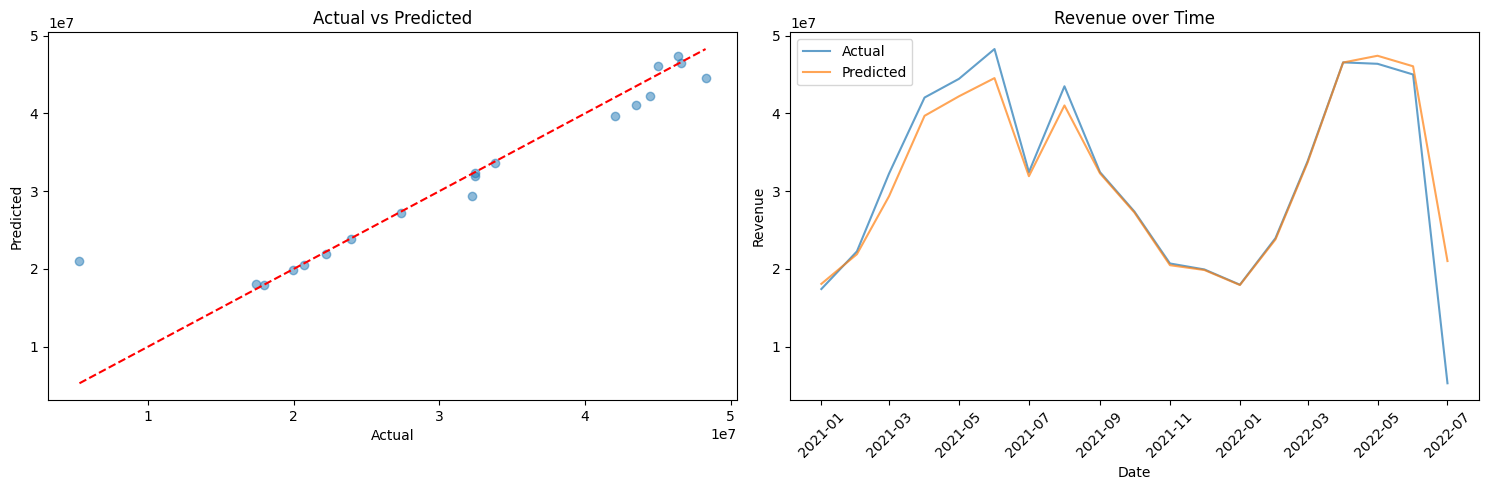

In [11]:
# Visualize kết quả
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")

# Plot 2: Predictions over time
plt.subplot(1, 2, 2)
plt.plot(monthly_test["Date"], y_test, label="Actual", alpha=0.7)
plt.plot(monthly_test["Date"], test_pred, label="Predicted", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue over Time")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [12]:
# Top important features
importance_dict = model.get_score(importance_type="gain")
importance_df = pd.DataFrame(
    [(k, v) for k, v in importance_dict.items()], columns=["feature", "importance"]
).sort_values("importance", ascending=False)

print("\nTop 10 Important Features:")
print(importance_df.head(10))

# So sánh theo tháng
results_df = pd.DataFrame(
    {"Date": monthly_test["Date"], "Actual": y_test, "Predicted": test_pred}
)

monthly_comparison = results_df.set_index("Date").resample("M").sum()
monthly_comparison["Sai khác (%)"] = abs(
    (monthly_comparison["Actual"] - monthly_comparison["Predicted"])
    / monthly_comparison["Actual"]
    * 100
)
print("\nSo sánh theo tháng:")
print(monthly_comparison.round(2))

# So sánh theo năm
results_df = pd.DataFrame(
    {"Date": monthly_test["Date"], "Actual": y_test, "Predicted": test_pred}
)

yearly_comparison = results_df.set_index("Date").resample("Y").sum()
yearly_comparison["Sai khác (%)"] = abs(
    (yearly_comparison["Actual"] - yearly_comparison["Predicted"])
    / yearly_comparison["Actual"]
    * 100
)
print("\nSo sánh theo năm:")
print(yearly_comparison.round(2))

# Thêm phần so sánh theo quý nếu cần
quarterly_comparison = results_df.set_index("Date").resample("Q").sum()
quarterly_comparison["Sai khác (%)"] = abs(
    (quarterly_comparison["Actual"] - quarterly_comparison["Predicted"])
    / quarterly_comparison["Actual"]
    * 100
)
print("\nSo sánh theo quý:")
print(quarterly_comparison.round(2))


Top 10 Important Features:
   feature    importance
1       f1  8.647431e+14
0       f0  8.306637e+14
31     f32  7.714849e+14
30     f31  6.256636e+14
10     f11  5.650465e+14
26     f27  2.828611e+14
27     f28  2.115572e+14
45     f46  6.181497e+13
37     f38  6.136291e+13
36     f37  5.911593e+13

So sánh theo tháng:
                 Actual   Predicted  Sai khác (%)
Date                                             
2021-01-31  17404126.74  18068942.0          3.82
2021-02-28  22244195.61  21884854.0          1.62
2021-03-31  32252658.48  29339952.0          9.03
2021-04-30  42042708.54  39691652.0          5.59
2021-05-31  44448474.42  42202196.0          5.05
2021-06-30  48282093.72  44543960.0          7.74
2021-07-31  32444287.47  31922590.0          1.61
2021-08-31  43491476.70  41024820.0          5.67
2021-09-30  32441185.98  32286448.0          0.48
2021-10-31  27373566.78  27250934.0          0.45
2021-11-30  20693577.24  20472210.0          1.07
2021-12-31  19926137.70  1

Tháng cuối cùng sai khác tận 297% chứng tỏ tháng cuối cùng data bị thiếu, chúng ta sẽ loại bỏ tháng cuối cùng và kiểm tra lại


In [13]:
# Select specific months for prediction
# For example, let's predict for January and February 2021
selected_months = monthly_test[
    (monthly_test["Date"].dt.year == 2021)
    & (monthly_test["Date"].dt.month.isin([1, 2]))
]

# Prepare the data
X_selected = selected_months.drop(["Date", "Revenue"], axis=1)
y_selected_actual = selected_months["Revenue"]

# Scale the features
X_selected_scaled = scaler.transform(X_selected)

# Create DMatrix for XGBoost
dselected = xgb.DMatrix(X_selected_scaled)

# Make predictions
y_selected_pred = model.predict(dselected)

# Evaluate predictions
print("Selected Months Predictions:")
for date, actual, pred in zip(
    selected_months["Date"], y_selected_actual, y_selected_pred
):
    print(f"Date: {date}, Actual Revenue: {actual}, Predicted Revenue: {pred}")

# Optionally, calculate metrics for these months
selected_rmse = np.sqrt(mean_squared_error(y_selected_actual, y_selected_pred))
selected_mape = np.mean(
    np.abs((y_selected_actual - y_selected_pred) / y_selected_actual) * 100
)

print(f"\nSelected Months RMSE: {selected_rmse:,.2f}")
print(f"Selected Months MAPE: {selected_mape:.2f}%")

Selected Months Predictions:
Date: 2021-01-01 00:00:00, Actual Revenue: 17404126.740000002, Predicted Revenue: 18068942.0
Date: 2021-02-01 00:00:00, Actual Revenue: 22244195.61, Predicted Revenue: 21884854.0

Selected Months RMSE: 534,371.46
Selected Months MAPE: 2.72%


In [14]:
# Loại bỏ tháng cuối cùng khỏi tập test
test_data_filtered = test_data[test_data["Date"] < "2022-07-01"]

# Tạo dữ liệu tổng hợp theo tháng sau khi loại bỏ tháng cuối cùng
monthly_test_filtered = create_monthly_features(test_data_filtered)

# Chuẩn bị dữ liệu cho mô hình
X_test_filtered = monthly_test_filtered.drop(["Date", "Revenue"], axis=1)
y_test_filtered = monthly_test_filtered["Revenue"]

# Scale features
X_test_filtered_scaled = scaler.transform(X_test_filtered)

dtest_filtered = xgb.DMatrix(X_test_filtered_scaled)

test_pred_filtered = model.predict(dtest_filtered)

# So sánh theo tháng sau khi loại bỏ tháng cuối cùng
results_df_filtered = pd.DataFrame(
    {
        "Date": monthly_test_filtered["Date"],
        "Actual": y_test_filtered,
        "Predicted": test_pred_filtered,
    }
)

monthly_comparison_filtered = results_df_filtered.set_index("Date").resample("M").sum()
monthly_comparison_filtered["Sai khác (%)"] = abs(
    (monthly_comparison_filtered["Actual"] - monthly_comparison_filtered["Predicted"])
    / monthly_comparison_filtered["Actual"]
    * 100
)
print("\nSo sánh theo tháng (sau khi loại bỏ tháng cuối cùng):")
print(monthly_comparison_filtered.round(2))

# So sánh theo năm sau khi loại bỏ tháng cuối cùng
yearly_comparison_filtered = results_df_filtered.set_index("Date").resample("Y").sum()
yearly_comparison_filtered["Sai khác (%)"] = abs(
    (yearly_comparison_filtered["Actual"] - yearly_comparison_filtered["Predicted"])
    / yearly_comparison_filtered["Actual"]
    * 100
)
print("\nSo sánh theo năm (sau khi loại bỏ tháng cuối cùng):")
print(yearly_comparison_filtered.round(2))

# So sánh theo quý sau khi loại bỏ tháng cuối cùng
quarterly_comparison_filtered = (
    results_df_filtered.set_index("Date").resample("Q").sum()
)
quarterly_comparison_filtered["Sai khác (%)"] = abs(
    (
        quarterly_comparison_filtered["Actual"]
        - quarterly_comparison_filtered["Predicted"]
    )
    / quarterly_comparison_filtered["Actual"]
    * 100
)
print("\nSo sánh theo quý (sau khi loại bỏ tháng cuối cùng):")
print(quarterly_comparison_filtered.round(2))


So sánh theo tháng (sau khi loại bỏ tháng cuối cùng):
                 Actual   Predicted  Sai khác (%)
Date                                             
2021-01-31  17404126.74  18068942.0          3.82
2021-02-28  22244195.61  21884854.0          1.62
2021-03-31  32252658.48  29339952.0          9.03
2021-04-30  42042708.54  39691652.0          5.59
2021-05-31  44448474.42  42202196.0          5.05
2021-06-30  48282093.72  44543960.0          7.74
2021-07-31  32444287.47  31922590.0          1.61
2021-08-31  43491476.70  41024820.0          5.67
2021-09-30  32441185.98  32286448.0          0.48
2021-10-31  27373566.78  27250934.0          0.45
2021-11-30  20693577.24  20472210.0          1.07
2021-12-31  19926137.70  19852118.0          0.37
2022-01-31  17959235.49  17922568.0          0.20
2022-02-28  23949100.98  23783444.0          0.69
2022-03-31  33834812.76  33671112.0          0.48
2022-04-30  46567715.67  46549064.0          0.04
2022-05-31  46384317.00  47418752.0          

In [15]:
# Đánh giá mô hình sau khi loại bỏ tháng cuối cùng
print("\nĐánh giá mô hình sau khi loại bỏ tháng cuối cùng:")
evaluate_predictions(y_train, train_pred, "Training Set")
evaluate_predictions(y_test_filtered, test_pred_filtered, "Filtered Test Set")


Đánh giá mô hình sau khi loại bỏ tháng cuối cùng:

Training Set Metrics:
RMSE: 1,478,150.56
MAE: 661,937.06
R2 Score: 0.9927
MAPE: 1.63%

Filtered Test Set Metrics:
RMSE: 1,532,869.01
MAE: 1,017,178.18
R2 Score: 0.9797
MAPE: 2.69%


# Huấn luyện mô hình dự đoán Units


In [16]:
# Huấn luyện mô hình dự đoán Units
print("\n=== Huấn luyện mô hình dự đoán Units ===")

# Chuẩn bị features cho model Units
features_to_drop_units = ["Date", "Units"]
target_units = "Units"

X_train_units = monthly_train.drop(features_to_drop_units, axis=1)
y_train_units = monthly_train[target_units]
X_test_units = monthly_test.drop(features_to_drop_units, axis=1)
y_test_units = monthly_test[target_units]

# Scale features
scaler_units = StandardScaler()
X_train_units_scaled = scaler_units.fit_transform(X_train_units)
X_test_units_scaled = scaler_units.transform(X_test_units)



=== Huấn luyện mô hình dự đoán Units ===


In [17]:
# Modify parameters for Units prediction
params_units = {
    "objective": "reg:squarederror",
    "eval_metric": ["rmse", "mae"],
    "max_depth": 4,
    "learning_rate": 0.02,
    "n_estimators": 1100,
    "min_child_weight": 8,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "gamma": 1.0,
    "reg_alpha": 1.5,
    "reg_lambda": 4.0,
    "random_state": 42,
}


In [18]:
# Time-series cross validation for Units
cv_scores_rmse_units = []
cv_scores_mape_units = []

print("\nPerforming Time Series Cross-validation for Units prediction...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_units_scaled)):
    X_train_cv_units = X_train_units_scaled[train_idx]
    y_train_cv_units = y_train_units.iloc[train_idx]
    X_val_cv_units = X_train_units_scaled[val_idx]
    y_val_cv_units = y_train_units.iloc[val_idx]

    dtrain_cv_units = xgb.DMatrix(X_train_cv_units, label=y_train_cv_units)
    dval_cv_units = xgb.DMatrix(X_val_cv_units, label=y_val_cv_units)

    model_cv_units = xgb.train(
        params_units,
        dtrain_cv_units,
        num_boost_round=1000,
        evals=[(dtrain_cv_units, "train"), (dval_cv_units, "val")],
        early_stopping_rounds=50,
        verbose_eval=False,
    )

    val_pred_units = model_cv_units.predict(dval_cv_units)

    rmse_units = np.sqrt(mean_squared_error(y_val_cv_units, val_pred_units))
    mape_units = np.mean(
        np.abs((y_val_cv_units - val_pred_units) / y_val_cv_units) * 100
    )

    cv_scores_rmse_units.append(rmse_units)
    cv_scores_mape_units.append(mape_units)

    print(f"Fold {fold + 1}: RMSE = {rmse_units:,.2f}, MAPE = {mape_units:.2f}%")

print("\nCross-validation Results for Units:")
print(
    f"Average RMSE: {np.mean(cv_scores_rmse_units):,.2f} (±{np.std(cv_scores_rmse_units):,.2f})"
)
print(
    f"Average MAPE: {np.mean(cv_scores_mape_units):.2f}% (±{np.std(cv_scores_mape_units):.2f}%)"
)



Performing Time Series Cross-validation for Units prediction...


Fold 1: RMSE = 2,485.03, MAPE = 21.09%
Fold 2: RMSE = 1,301.64, MAPE = 12.30%
Fold 3: RMSE = 2,100.90, MAPE = 31.35%
Fold 4: RMSE = 1,166.22, MAPE = 32.89%
Fold 5: RMSE = 308.84, MAPE = 6.99%

Cross-validation Results for Units:
Average RMSE: 1,472.52 (±761.21)
Average MAPE: 20.93% (±10.20%)


In [19]:
# Train final model for Units prediction
print("\nTraining final model for Units prediction...")
dtrain_units = xgb.DMatrix(X_train_units_scaled, label=y_train_units)
dtest_units = xgb.DMatrix(X_test_units_scaled, label=y_test_units)

model_units = xgb.train(
    params_units,
    dtrain_units,
    num_boost_round=1000,
    evals=[(dtrain_units, "train"), (dtest_units, "test")],
    early_stopping_rounds=50,
    verbose_eval=200,
)


Training final model for Units prediction...
[0]	train-rmse:3500.97692	train-mae:2917.13528	test-rmse:3617.81479	test-mae:3280.12796
[200]	train-rmse:502.62101	train-mae:314.02793	test-rmse:854.95168	test-mae:592.77795
[400]	train-rmse:259.42731	train-mae:157.23180	test-rmse:746.72956	test-mae:502.50709
[600]	train-rmse:169.18319	train-mae:97.31066	test-rmse:733.81717	test-mae:492.98796
[800]	train-rmse:115.06084	train-mae:61.00817	test-rmse:727.88003	test-mae:488.81806
[842]	train-rmse:107.12147	train-mae:55.67693	test-rmse:727.29574	test-mae:488.78748


In [20]:
# Dự đoán Units
train_pred_units = model_units.predict(dtrain_units)
test_pred_units = model_units.predict(dtest_units)

# Đánh giá mô hình Units
print("\nĐánh giá mô hình dự đoán Units:")
evaluate_predictions(y_train_units, train_pred_units, "Training Set (Units)")
evaluate_predictions(y_test_units, test_pred_units, "Test Set (Units)")

# So sánh theo tháng cho Units
results_df_units = pd.DataFrame(
    {"Date": monthly_test["Date"], "Actual": y_test_units, "Predicted": test_pred_units}
)

monthly_comparison_units = results_df_units.set_index("Date").resample("M").sum()
monthly_comparison_units["Sai khác (%)"] = abs(
    (monthly_comparison_units["Actual"] - monthly_comparison_units["Predicted"])
    / monthly_comparison_units["Actual"]
    * 100
)
print("\nSo sánh Units theo tháng:")
print(monthly_comparison_units.round(2))



Đánh giá mô hình dự đoán Units:

Training Set (Units) Metrics:
RMSE: 106.78
MAE: 55.39
R2 Score: 0.9991
MAPE: 0.78%

Test Set (Units) Metrics:
RMSE: 727.29
MAE: 488.78
R2 Score: 0.7768
MAPE: 23.83%

So sánh Units theo tháng:
            Actual    Predicted  Sai khác (%)
Date                                         
2021-01-31    2212  2651.340088         19.86
2021-02-28    2824  2961.679932          4.88
2021-03-31    4226  3984.939941          5.70
2021-04-30    5456  4905.589844         10.09
2021-05-31    5745  5052.459961         12.05
2021-06-30    6176  7803.240234         26.35
2021-07-31    4127  4147.330078          0.49
2021-08-31    5535  5221.640137          5.66
2021-09-30    3814  4047.919922          6.13
2021-10-31    3284  3118.840088          5.03
2021-11-30    2593  2752.370117          6.15
2021-12-31    3243  3080.389893          5.01
2022-01-31    2184  2447.709961         12.07
2022-02-28    2887  3001.840088          3.98
2022-03-31    4242  4285.850098       

In [21]:
# So sánh theo năm cho Units
yearly_comparison_units = results_df_units.set_index("Date").resample("Y").sum()
yearly_comparison_units["Sai khác (%)"] = abs(
    (yearly_comparison_units["Actual"] - yearly_comparison_units["Predicted"])
    / yearly_comparison_units["Actual"]
    * 100
)
print("\nSo sánh Units theo năm:")
print(yearly_comparison_units.round(2))

# So sánh theo quý cho Units
quarterly_comparison_units = results_df_units.set_index("Date").resample("Q").sum()
quarterly_comparison_units["Sai khác (%)"] = abs(
    (quarterly_comparison_units["Actual"] - quarterly_comparison_units["Predicted"])
    / quarterly_comparison_units["Actual"]
    * 100
)
print("\nSo sánh Units theo quý:")
print(quarterly_comparison_units.round(2))



So sánh Units theo năm:
            Actual     Predicted  Sai khác (%)
Date                                          
2021-12-31   49235  49727.738281          1.00
2022-12-31   27401  31944.779297         16.58

So sánh Units theo quý:
            Actual     Predicted  Sai khác (%)
Date                                          
2021-03-31    9262   9597.959961          3.63
2021-06-30   17377  17761.279297          2.21
2021-09-30   13476  13416.889648          0.44
2021-12-31    9120   8951.610352          1.85
2022-03-31    9313   9735.410156          4.54
2022-06-30   17375  19404.300781         11.68
2022-09-30     713   2805.070068        293.42


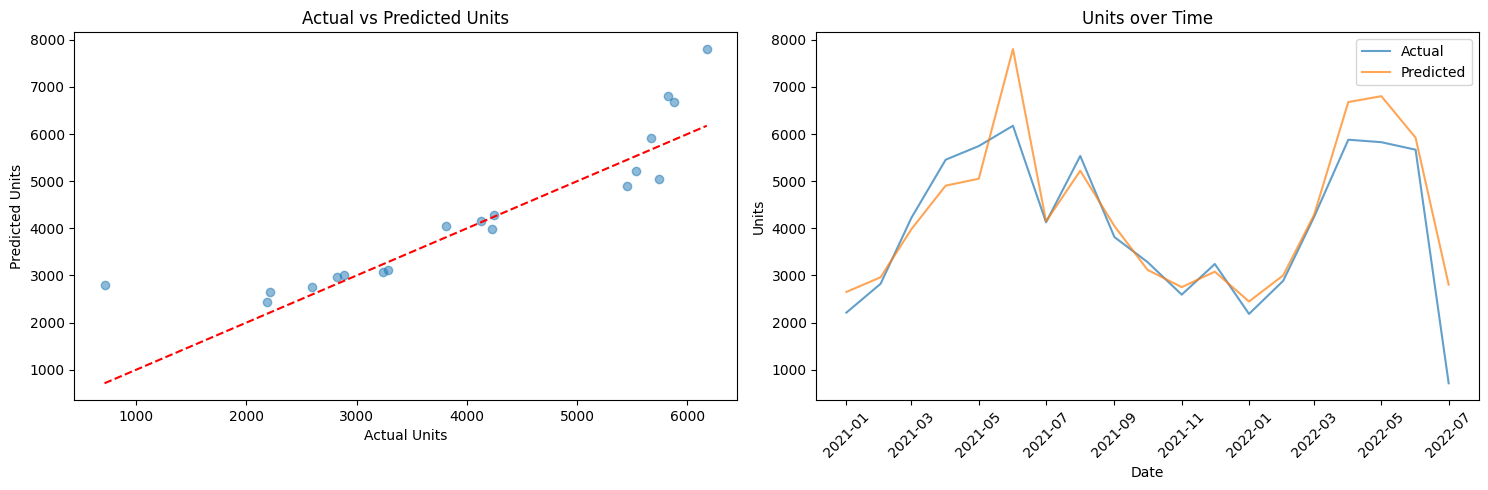

In [22]:
# Visualize kết quả Units
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted Units
plt.subplot(1, 2, 1)
plt.scatter(y_test_units, test_pred_units, alpha=0.5)
plt.plot(
    [y_test_units.min(), y_test_units.max()],
    [y_test_units.min(), y_test_units.max()],
    "r--",
)
plt.xlabel("Actual Units")
plt.ylabel("Predicted Units")
plt.title("Actual vs Predicted Units")

# Plot 2: Units Predictions over time
plt.subplot(1, 2, 2)
plt.plot(monthly_test["Date"], y_test_units, label="Actual", alpha=0.7)
plt.plot(monthly_test["Date"], test_pred_units, label="Predicted", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Units")
plt.title("Units over Time")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [23]:
# Top important features for Units prediction
importance_dict_units = model_units.get_score(importance_type="gain")
importance_df_units = pd.DataFrame(
    [(k, v) for k, v in importance_dict_units.items()],
    columns=["feature", "importance"],
).sort_values("importance", ascending=False)

print("\nTop 10 Important Features for Units Prediction:")
print(importance_df_units.head(10))



Top 10 Important Features for Units Prediction:
   feature   importance
0       f0  45482316.00
1       f1  40192800.00
31     f32  24069184.00
4       f5  21001740.00
27     f28  19868806.00
39     f40   8186641.50
44     f45   3663112.00
35     f36   3457186.00
45     f46   2992293.25
19     f20   2714959.75


In [24]:
# Loại bỏ tháng cuối cùng và kiểm tra lại cho Units
test_data_filtered = test_data[test_data["Date"] < "2022-07-01"]
monthly_test_filtered = create_monthly_features(test_data_filtered)

X_test_filtered_units = monthly_test_filtered.drop(["Date", "Units"], axis=1)
y_test_filtered_units = monthly_test_filtered["Units"]

X_test_filtered_units_scaled = scaler_units.transform(X_test_filtered_units)
dtest_filtered_units = xgb.DMatrix(X_test_filtered_units_scaled)

test_pred_filtered_units = model_units.predict(dtest_filtered_units)

print("\nĐánh giá mô hình Units sau khi loại bỏ tháng cuối cùng:")
evaluate_predictions(y_train_units, train_pred_units, "Training Set (Units)")
evaluate_predictions(
    y_test_filtered_units, test_pred_filtered_units, "Filtered Test Set (Units)"
)


Đánh giá mô hình Units sau khi loại bỏ tháng cuối cùng:

Training Set (Units) Metrics:
RMSE: 106.78
MAE: 55.39
R2 Score: 0.9991
MAPE: 0.78%

Filtered Test Set (Units) Metrics:
RMSE: 561.41
MAE: 399.71
R2 Score: 0.8301
MAPE: 8.85%



=== Trực quan hóa kết quả sau khi loại bỏ tháng cuối cùng ===


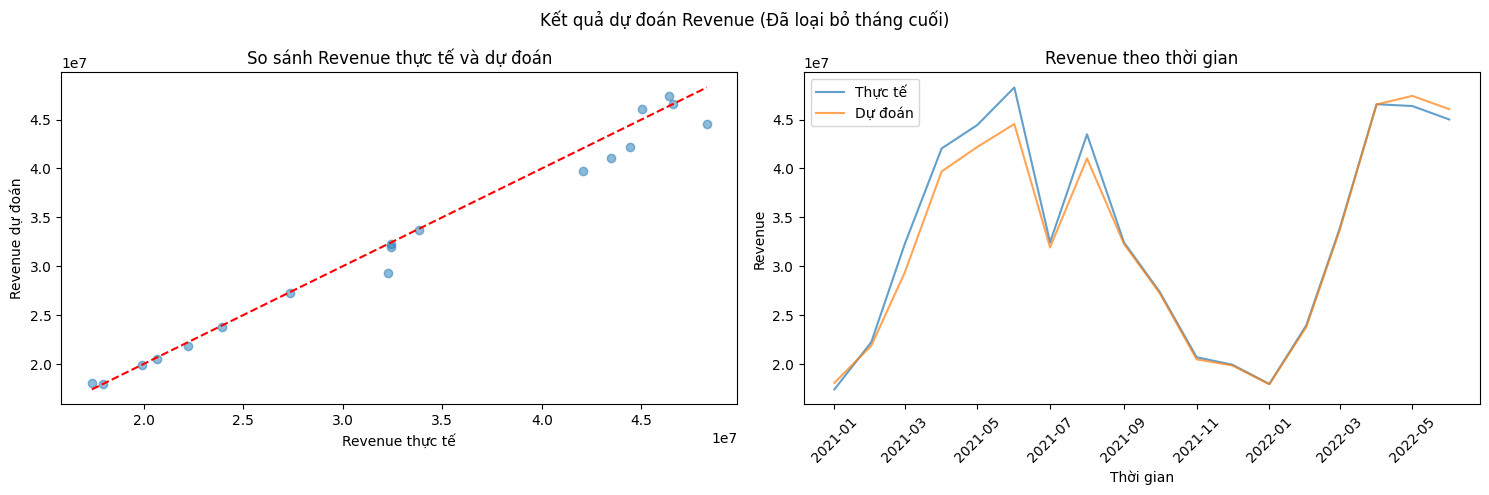

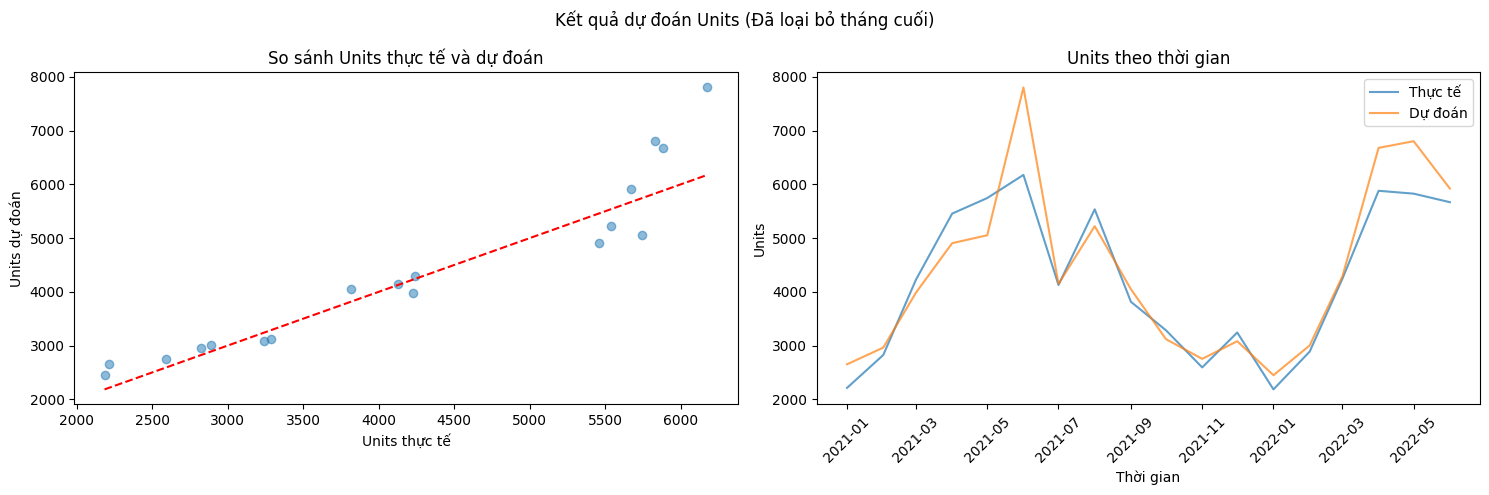

In [25]:
# Trực quan hóa kết quả sau khi loại bỏ tháng cuối cùng
print("\n=== Trực quan hóa kết quả sau khi loại bỏ tháng cuối cùng ===")

# Visualize kết quả Revenue
plt.figure(figsize=(15, 5))
plt.suptitle("Kết quả dự đoán Revenue (Đã loại bỏ tháng cuối)")

# Plot 1: Actual vs Predicted Revenue
plt.subplot(1, 2, 1)
plt.scatter(y_test_filtered, test_pred_filtered, alpha=0.5)
plt.plot(
    [y_test_filtered.min(), y_test_filtered.max()],
    [y_test_filtered.min(), y_test_filtered.max()],
    "r--",
)
plt.xlabel("Revenue thực tế")
plt.ylabel("Revenue dự đoán")
plt.title("So sánh Revenue thực tế và dự đoán")

# Plot 2: Revenue Predictions over time
plt.subplot(1, 2, 2)
plt.plot(monthly_test_filtered["Date"], y_test_filtered, label="Thực tế", alpha=0.7)
plt.plot(monthly_test_filtered["Date"], test_pred_filtered, label="Dự đoán", alpha=0.7)
plt.xlabel("Thời gian")
plt.ylabel("Revenue")
plt.title("Revenue theo thời gian")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Visualize kết quả Units
plt.figure(figsize=(15, 5))
plt.suptitle("Kết quả dự đoán Units (Đã loại bỏ tháng cuối)")

# Plot 1: Actual vs Predicted Units
plt.subplot(1, 2, 1)
plt.scatter(y_test_filtered_units, test_pred_filtered_units, alpha=0.5)
plt.plot(
    [y_test_filtered_units.min(), y_test_filtered_units.max()],
    [y_test_filtered_units.min(), y_test_filtered_units.max()],
    "r--",
)
plt.xlabel("Units thực tế")
plt.ylabel("Units dự đoán")
plt.title("So sánh Units thực tế và dự đoán")

# Plot 2: Units Predictions over time
plt.subplot(1, 2, 2)
plt.plot(
    monthly_test_filtered["Date"], y_test_filtered_units, label="Thực tế", alpha=0.7
)
plt.plot(
    monthly_test_filtered["Date"], test_pred_filtered_units, label="Dự đoán", alpha=0.7
)
plt.xlabel("Thời gian")
plt.ylabel("Units")
plt.title("Units theo thời gian")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()